In [93]:
# imports and configs

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# make plots a bit bigger
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]


In [111]:
# load the datasets

df_c = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
df_d = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df_r = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

# next rotate them to add a Date column

ids = ["Province/State", "Country/Region", "Lat", "Long"]

df_c = df_c.melt(id_vars=ids, var_name="Date", value_name="Confirmed")
df_d = df_d.melt(id_vars=ids, var_name="Date", value_name="Deaths")
df_r = df_r.melt(id_vars=ids, var_name="Date", value_name="Recovered")

# next merge the Confirmed/Deaths/Recovered into one dataframe

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
keys = ["Province/State", "Country/Region", "Lat", "Long", "Date"]

df = pd.merge(df_c, df_d, how='outer', on=keys)
df = pd.merge(df, df_r, how='outer', on=keys)

# finally cleanup the dates (who uses M/D/Y in a dataset ???)

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

# write it for review

df.to_csv("csse-combined.csv", index=False)

#for c in df.columns:
#    u = df[c].unique()
#    print("%-20s %u" % (c, len(u)))

#print(df['Country/Region'].unique())

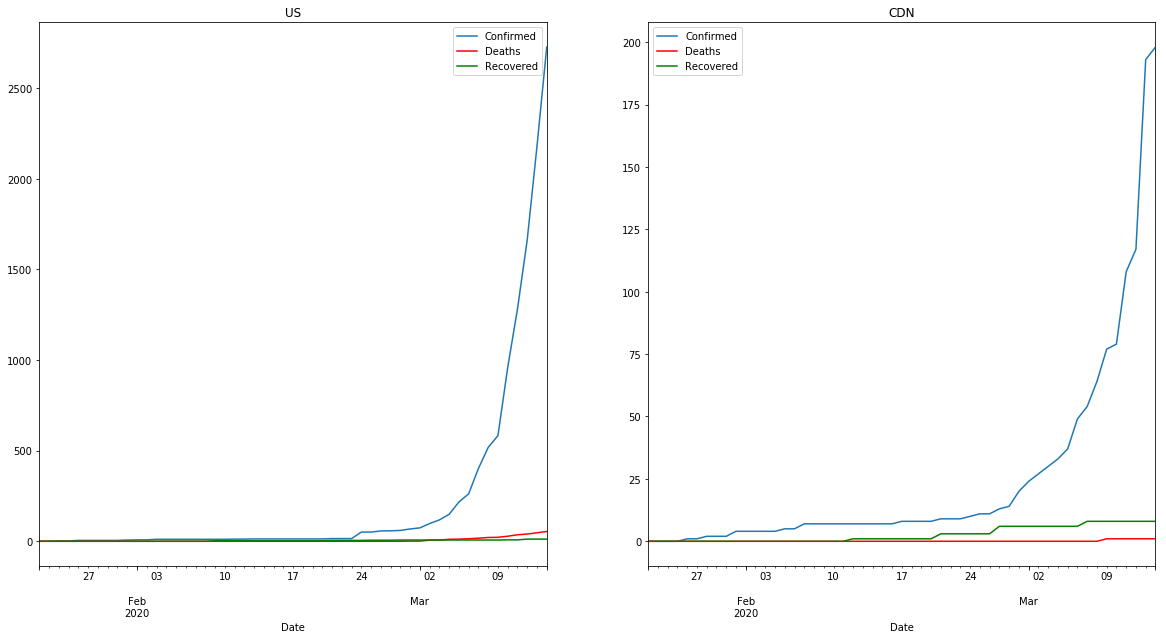

In [112]:
cdn = df.loc[df['Country/Region'] == 'Canada']
cdn = cdn.groupby(['Country/Region','Date'],as_index=False).agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})

ont = df.loc[df['Province/State'] == 'Ontario']

usa = df.loc[df['Country/Region'] == 'US']
usa = usa.groupby(['Country/Region','Date'],as_index=False).agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})


#print(cdn)
#print(ont)

#p = ont
#p = cdn

fig, (ax1, ax2) = plt.subplots(1, 2)

p = usa
ax1.set_title('US')
p.plot(kind='line',x='Date',y='Confirmed',ax=ax1)
p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax1)
p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax1)

p = cdn
ax2.set_title('CDN')
p.plot(kind='line',x='Date',y='Confirmed',ax=ax2)
p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax2)
p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax2)


plt.show()


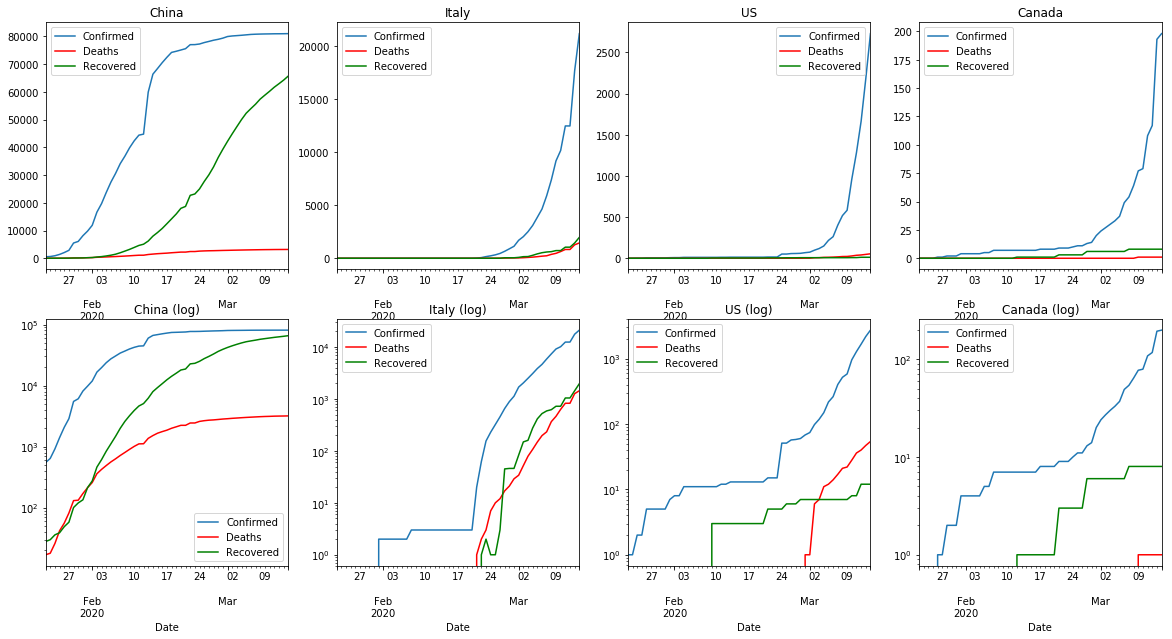

In [116]:

countries = ['China', 'Italy', 'US', 'Canada']

fig, axs = plt.subplots(2, len(countries))

i = 0
for country in countries:
    p = df.loc[df['Country/Region'] == country]
    p = p.groupby(['Country/Region','Date'],as_index=False).agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})

    ax = axs[0][i]
    ax.set_title(country)
    p.plot(kind='line',x='Date',y='Confirmed',ax=ax)
    p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax)

    ax = axs[1][i]
    ax.set_title("%s (log)" % country)
    p.plot(kind='line',x='Date',y='Confirmed',ax=ax)
    p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax)
    ax.set_yscale('log')
    
    i = i + 1

fig.savefig('out/countries.png')
plt.show()


['Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui' 'Jiangxi'
 'Shandong' 'Jiangsu' 'Chongqing']


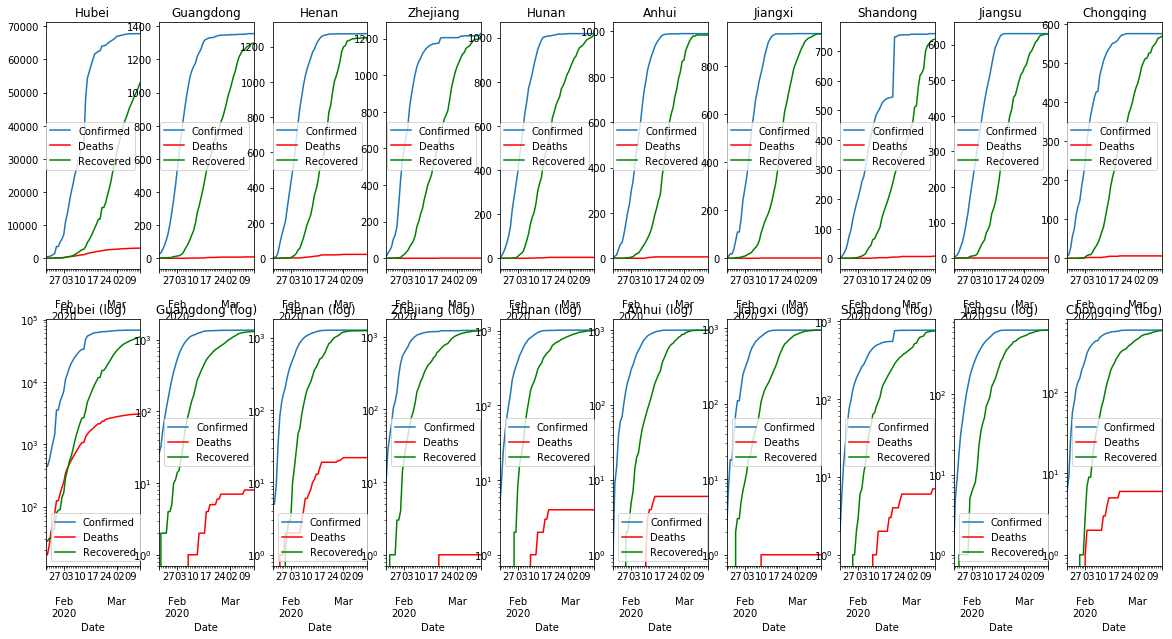

In [114]:
country = 'China'
cdf = df.loc[df['Country/Region'] == country]
regions = cdf['Province/State'].unique()
regions = regions[0:10]

print(regions)

fig, axs = plt.subplots(2, len(regions))

i = 0
for region in regions:
    p = cdf.loc[df['Province/State'] == region]
    p = p.groupby(['Province/State','Date'],as_index=False).agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})

    ax = axs[0][i]
    ax.set_title(region)
    p.plot(kind='line',x='Date',y='Confirmed',ax=ax)
    p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax)

    ax = axs[1][i]
    ax.set_title("%s (log)" % region)
    p.plot(kind='line',x='Date',y='Confirmed',ax=ax)
    p.plot(kind='line',x='Date',y='Deaths', color='red', ax=ax)
    p.plot(kind='line',x='Date',y='Recovered', color='green', ax=ax)
    ax.set_yscale('log')
    
    i = i + 1

plt.show()
